# 🏃 Human Activity Recognition – Assignment 1  
### 5ARE0, Academic Year 2025–2026  

**Group 13**  

**Contributors:**  
- Stan Lamerikx
- Simon Lammertink
- Philip Offermans

---

## 📦 Import Modules
Below all relevant packages which are used throughout the notebook are imported.\
The required packages are the same as the ones used throughout the course 5ARE0.\
When the setup is properly carried out according to the README.md file, all of these packages should be present.

In [283]:
import zipfile
import os
import glob
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

from pathlib import Path
from typing import Iterable, Dict, List, Optional, Tuple, Union
from __future__ import annotations
from typing import Dict, List
from scipy.signal import butter, filtfilt
from collections import Counter
from scipy.optimize import linear_sum_assignment

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## 📂 Data Loading

### Unzipping Data
All zipped datasets in the `./data` directory are extracted.  
Each zip file corresponds to one recording of an activity. The folder names follow the pattern `<activity>_x`, where `x` is the recording number:  
- **walking_x**  
- **running_x**  
- **climbingStairs_x**  
- **sittingDown+StandingUp_x** (this activity combines two actions in a single recording, which will be split during preprocessing)  

Since there are multiple recordings of an action, you will see several numbered folders for each activity (e.g., `walking_1`, `walking_2`, `walking_3`).

In [284]:
# Location of the data directory
zip_folder = "./data"

# Create an empty list to store the directories of extracted zips
data_dirs = []

# Loop through all files in the data directory
for file in os.listdir(zip_folder):
    # Process only files that end with ".zip"
    if file.endswith(".zip"):
        # Get the full path to the zip file
        zip_path = os.path.join(zip_folder, file)
        
        # Define the extraction directory
        extract_dir = os.path.splitext(zip_path)[0]
        
        # Keep track of the extracted directory
        data_dirs.append(extract_dir)
        
        # Extract the contents of the zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

### Defining Functions to Load Data
Three helper functions are defined to ensure the data can be loaded and prepared:  

1. **`_csv_to_df`:**  
    - Reads a `.csv` file into a Pandas DataFrame.  
    - Drops the `time` column, since we rely on `seconds_elapsed` as the time reference.  
    - Checks for missing values and, if found, fills them using linear interpolation and removes any remaining gaps.  
    - In practice, the dataset does not contain missing values.

2. **`_cut`:**  
    - Selects a time window within the DataFrame using the `seconds_elapsed` column.  
    - Keeps only rows between `t_min` and `t_max`.  
    - Resets the index and re-aligns time so that the new window starts at `t = 0s`.  
    - Ensures stable sorting by `seconds_elapsed` before processing.  

3. **`load_data`:**  
    - Iterates over all specified actions and their recordings.  
    - For each action, finds all matching recording directories using a glob pattern.  
    - Loads sensor data files (`.csv`) with `_csv_to_df`.  
    - Cuts the data to the relevant time window using `_cut`.  
    - Stores the processed data in a nested dictionary of the form:  
      ```python
      {
          action: {
              sensor: [DataFrame, DataFrame, ...]
          }
      }
      ```
      where each list contains all recordings for that sensor/action.  
    - Uses different time windows for `"sittingDown+StandingUp"` (25.0–565.1 s) and all other actions (25.0–295.1 s).

In [285]:
def _csv_to_df(csv_path: Path) -> pd.DataFrame:
    """
    Load a CSV file into a Pandas DataFrame.

    The column "time" is dropped, since "seconds_elapsed" is used as the 
    reference timestamp. If missing values are detected, they are 
    interpolated linearly.

    Parameters
    ----------
    csv_path : Path
        Path to the CSV file that should be converted.
    
    Returns
    -------
    pd.DataFrame
        Cleaned DataFrame containing the sensor data.
    """
    # Convert CSV to dataframe
    df = pd.read_csv(csv_path)

    # Remove time column 
    if "time" in df.columns:
        df = df.drop(columns=["time"])

    # Check and interpolate missing values
    if df.isna().any().any():
        print("MISSING VALUE")
        df = df.interpolate(method="linear").dropna()
    return df


def _cut(df: pd.DataFrame, t_min: float, t_max: float) -> pd.DataFrame:
    """
    Cut a DataFrame to a selected time window and reset the timeline.

    Keeps only the rows where "seconds_elapsed" falls within the 
    interval [t_min, t_max]. Resets the beginning of the time series 
    so that the first timestamp starts at 0 seconds.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing a "seconds_elapsed" column.
    t_min : float
        Start time of the cut (in seconds).
    t_max : float
        End time of the cut (in seconds).
    
    Returns
    -------
    pd.DataFrame
        DataFrame limited to the given time range, with time reset to 0.
    """
    # Select rows within the given time range [t_min, t_max]
    cut = df[(df["seconds_elapsed"] >= t_min) & (df["seconds_elapsed"] <= t_max)].copy()
    
    # Sort by time to ensure correct order
    cut.sort_values("seconds_elapsed", inplace=True, kind="stable")
    
    # Reset index after cutting
    cut.reset_index(drop=True, inplace=True)
    
    # Shift the timeline so that the new start is t = 0s
    cut["seconds_elapsed"] = cut["seconds_elapsed"] - cut["seconds_elapsed"].iloc[0]
    
    return cut


def load_data(sensors: list[str], actions: list[str], location: str = "./data/{action}*/") -> dict:
    """
    Load and segment sensor recordings for selected actions.

    For each action: this function finds all matching recording directories, 
    loads each requested sensor CSV, and cuts the time series to a 
    predefined window. The window differs for "sittingDown+StandingUp" 
    versus other actions.

    Parameters
    ----------
    sensors : list of str
        Sensor names used to build CSV paths.
    actions : list of str
        Activity labels that appear in the folder names.
    location : str
        A glob pattern with {action} placeholder that expands to the recording
        directories for a given action.

    Returns
    -------
    dict[str, dict[str, list[pd.DataFrame]]]
        Nested dictionary mapping
        '{ action: { sensor: [DataFrame, ...] } }' where each DataFrame is the
        cut time series for one recording of that sensor/action.
    """
    # Create empty dict to store data
    cut_data = {}

    # Go trough all actions
    for action in actions:
        # find all recordings for an action
        rec_dirs = [d for d in glob.glob(location.format(action=action))]
        
        # If the action is sitting down and standing up: set the begin and end time
        # For more details regarding these times, check recording methodology in report
        # The 0.1 at the end is added to make sure when sampling a full last sample can be made
        if action == "sittingDown+StandingUp":
            t_min, t_max = 25.0, 565.1

        # Else set begin and end time for all other actions
        # Times correspond to recording methodology discussed in report
        # The 0.1 at the end is added to make sure when sampling a full last sample can be made
        else:
            t_min, t_max = 25.0, 295.1

        # Create empty dict to store data of an action
        cut_data[action] = {}

        # Go trough all recordings
        for rec in rec_dirs:
            # Go trough all sensors
            for sensor in sensors:
                # Create location of csv
                csv_path = f"{rec}{sensor}.csv"

                # Use function created before to convert to dataframe
                df = _csv_to_df(csv_path)

                # Use function before to cut dataframe to appropriate begin and end time
                df_cut = _cut(df, t_min, t_max)
                
                # Initialize list if it doesn't exist
                if sensor not in cut_data[action]:
                    cut_data[action][sensor] = [df_cut]
                else:
                    cut_data[action][sensor].append(df_cut) 
    return cut_data

### Defining Sensors and Actions
To correctly extract only the data which we want to use, a list of strings is defined for both the sensors and actions which includes all desired data.

In [286]:
#Define relevant sensor data
SENSORS: list[str] = [
    "Accelerometer",
    "Gyroscope",
    "Gravity",
]

#Define list of actions
ACTIONS: list[str] = [
    "climbingStairs",
    "running",
    "sittingDown+StandingUp",
    "walking",
]

### Load Data
Finally, the data in the `./data` directory is loaded using the specified **SENSORS**, **ACTIONS**, and the helper functions defined above.

In [287]:
raw_data = load_data(sensors=SENSORS, actions=ACTIONS, location="./data/{action}*/")

### Visualize Data
The first 25 seconds and the last 25 seconds of each sample are visualised to show that there are no artifacts left from beginning and ending the recording.

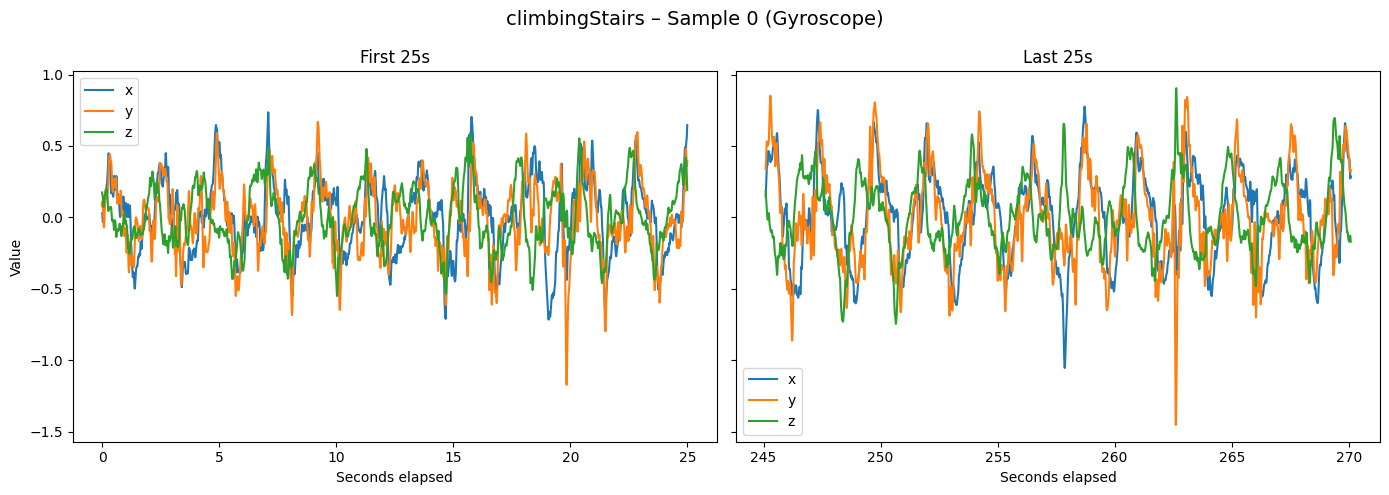

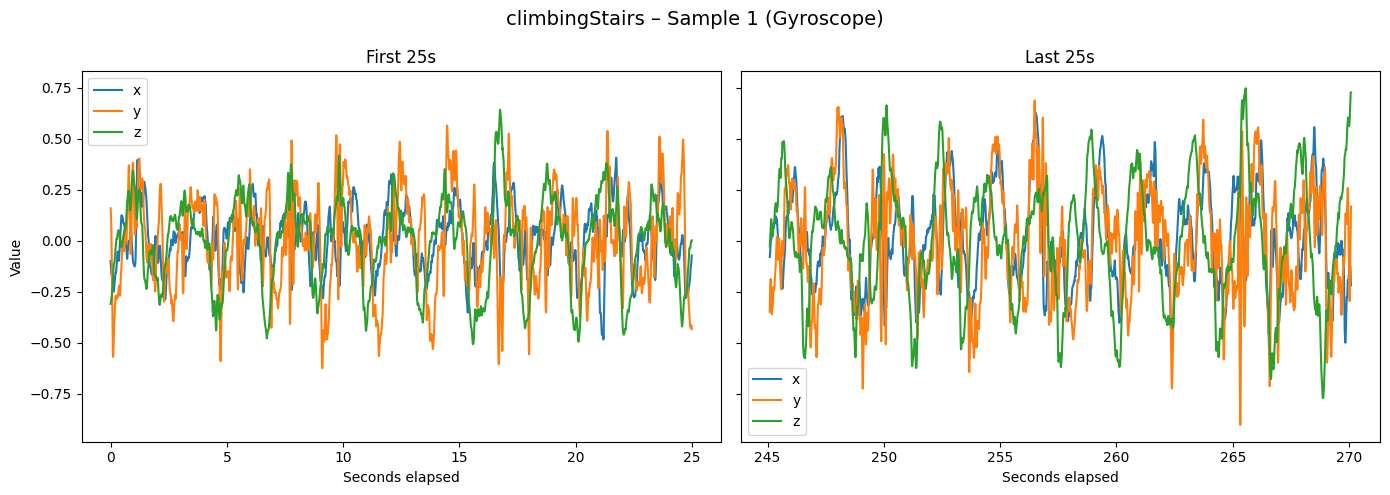

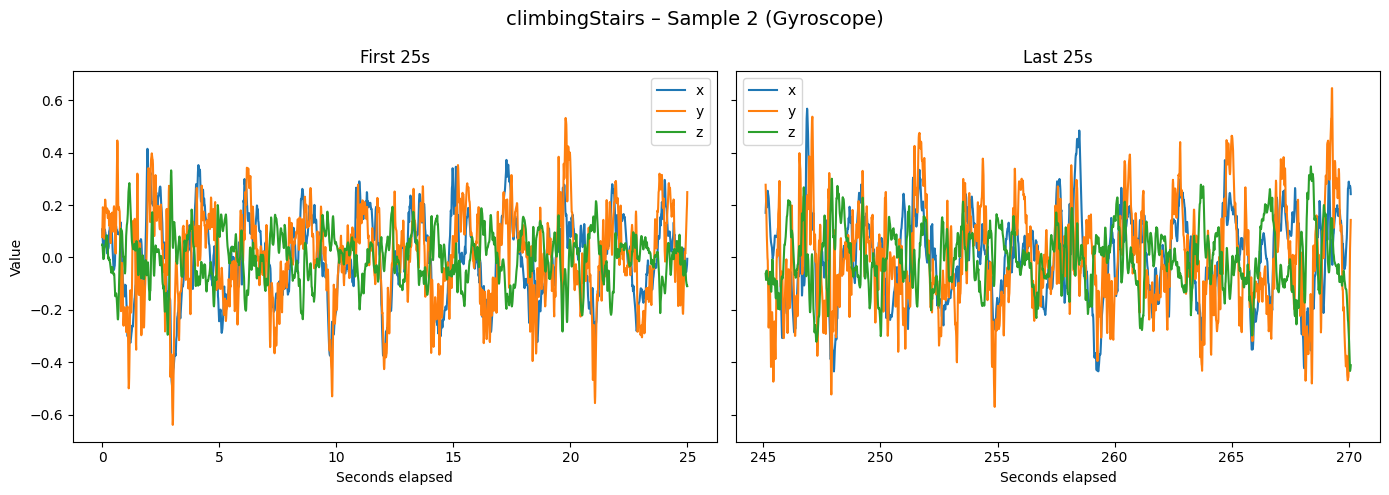

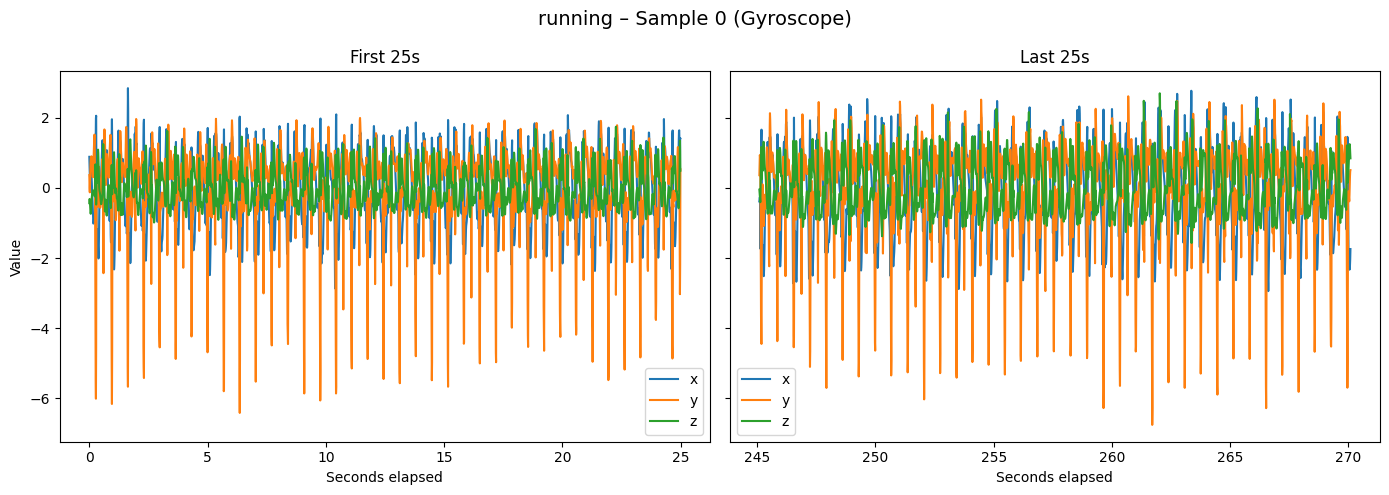

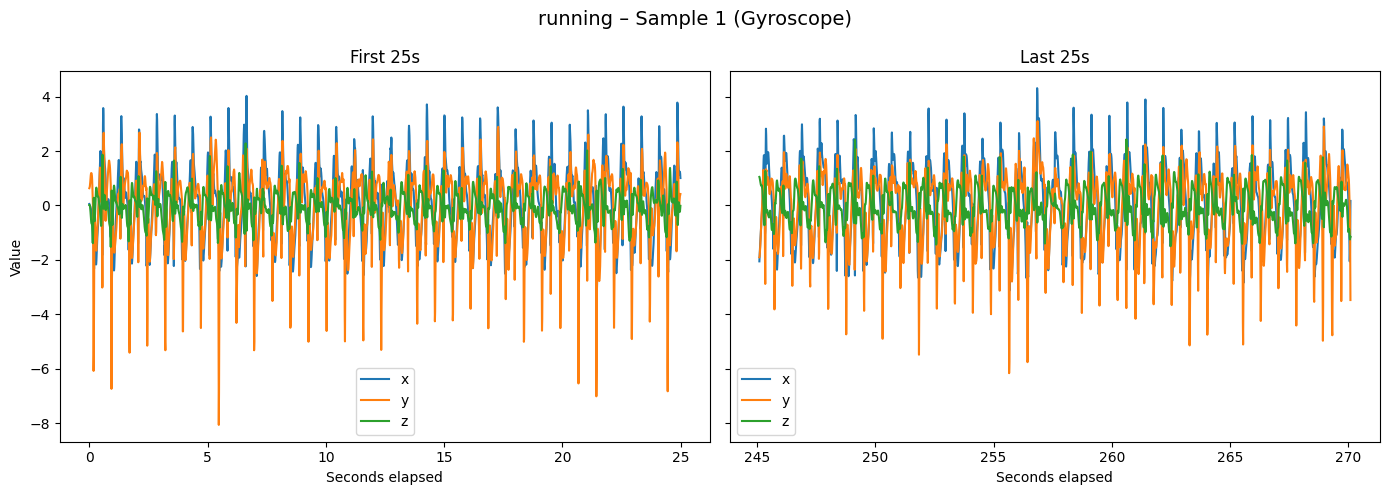

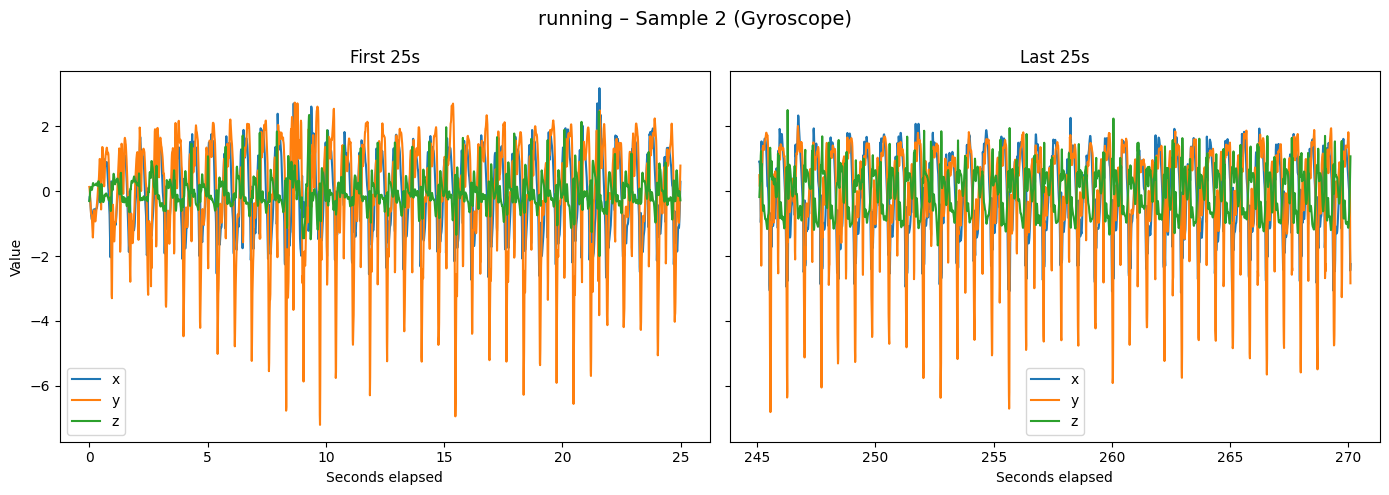

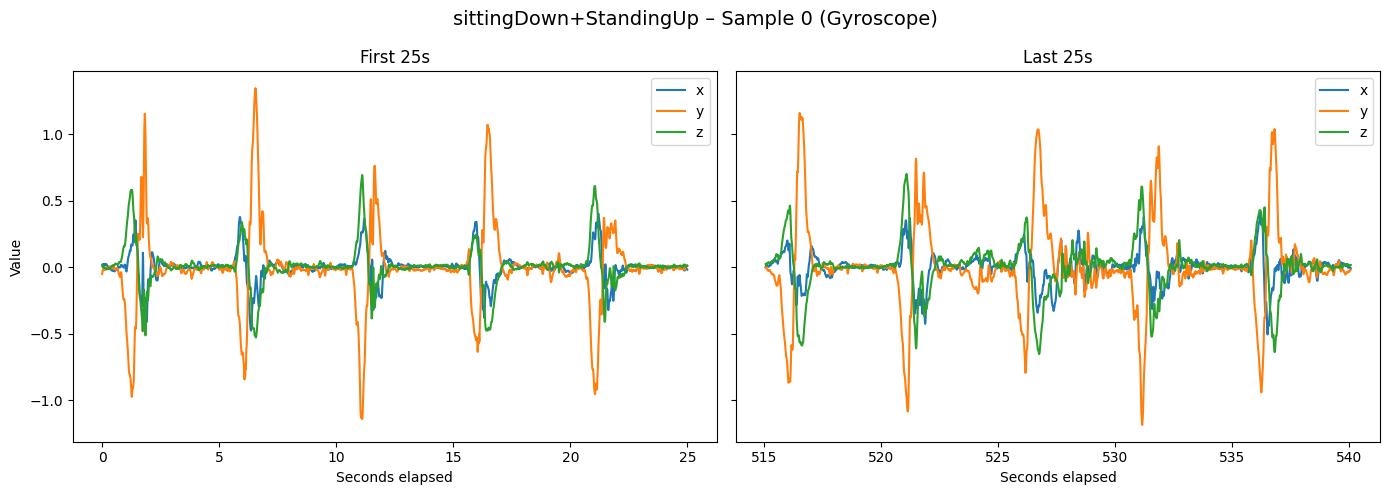

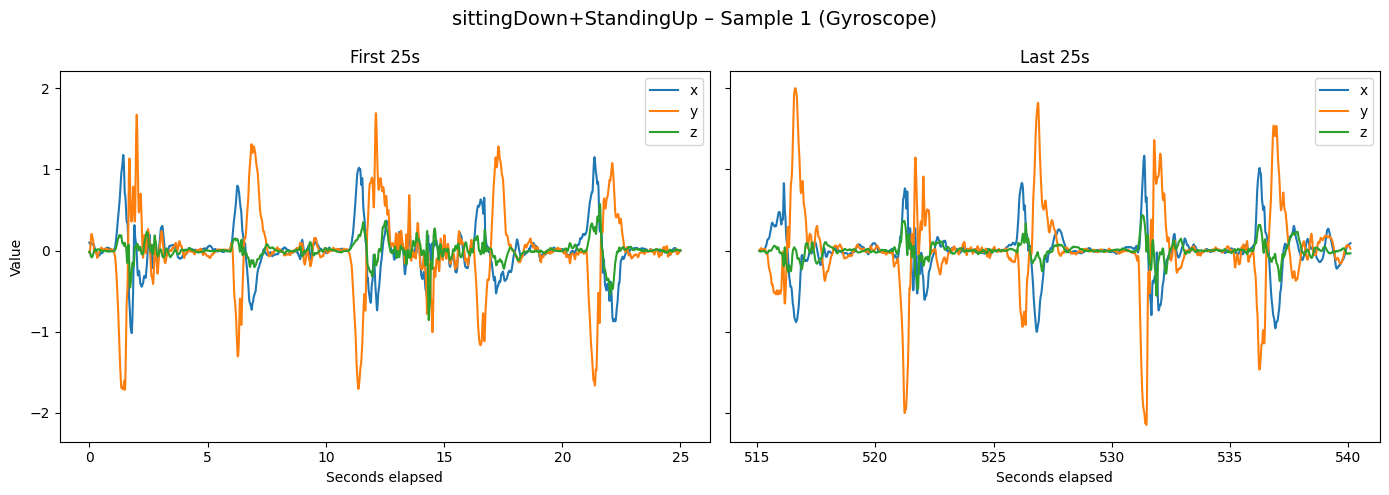

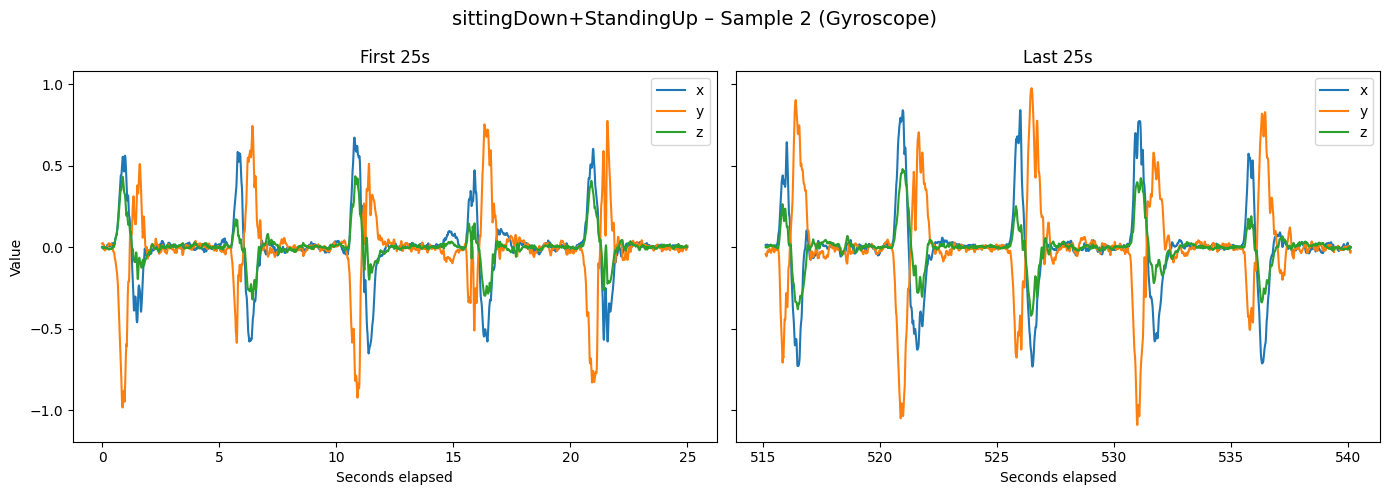

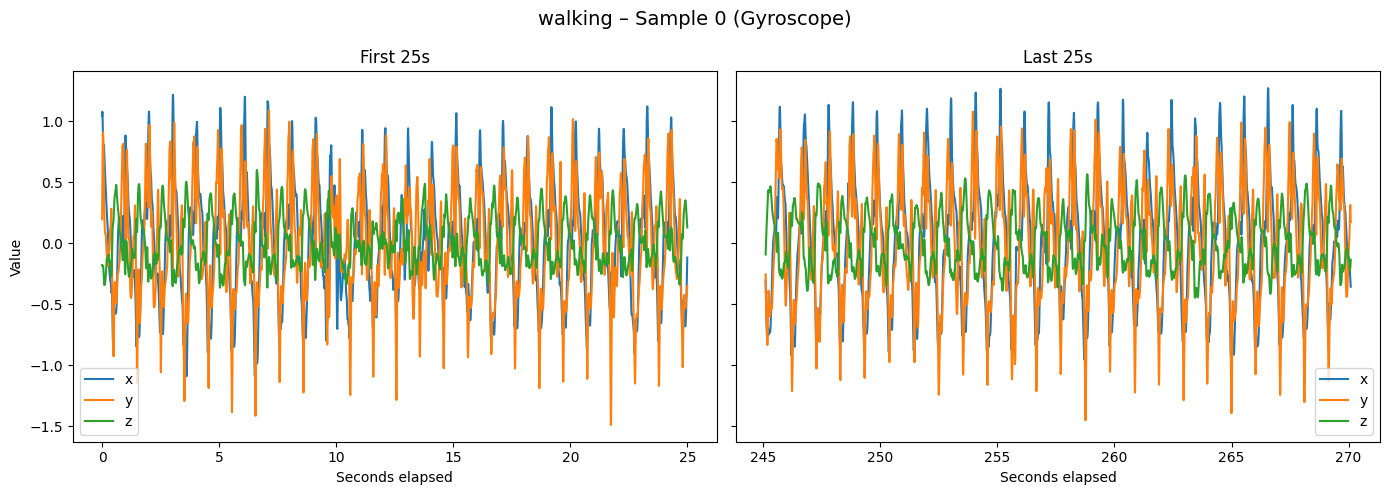

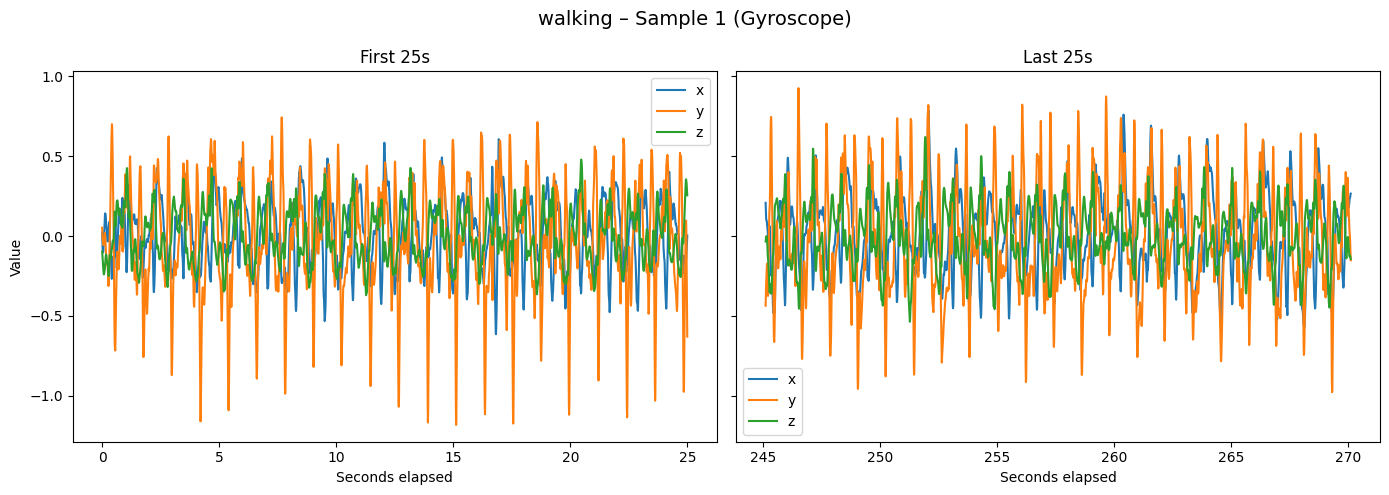

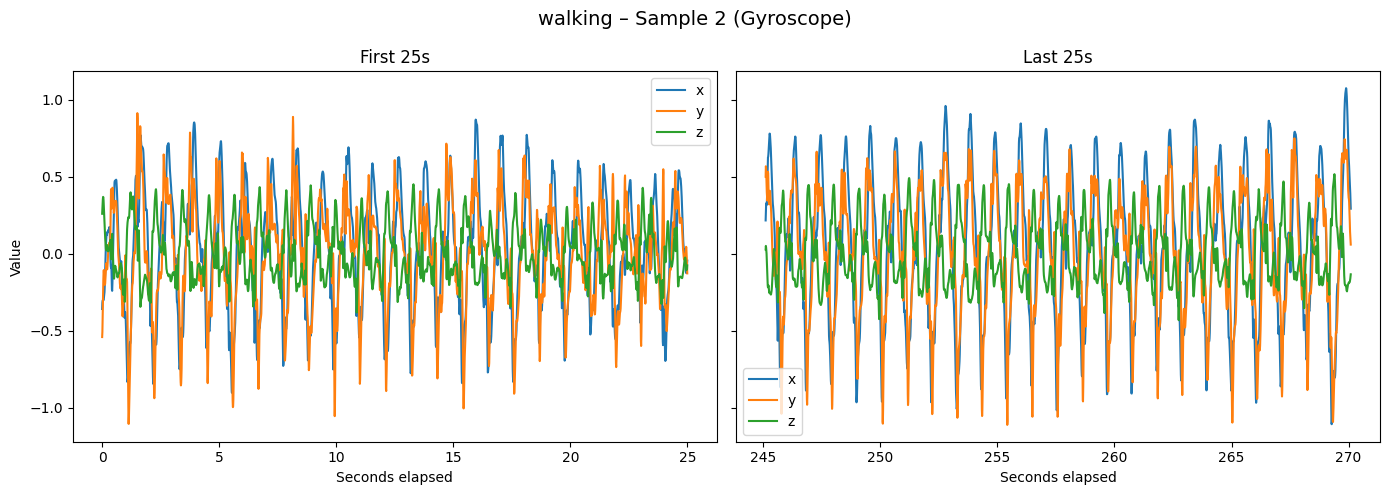

In [288]:
import matplotlib.pyplot as plt

# Loop through each action and its associated sensors
for action, sensors in raw_data.items():
    # Assume all sensors have the same number of samples
    n_samples = len(next(iter(sensors.values())))
    
    # Iterate through each sample
    for i in range(n_samples):  
        # Select the i-th Gyroscope sample (DataFrame with columns: seconds_elapsed, x, y, z)
        df = sensors["Gyroscope"][i]
        max_t = df["seconds_elapsed"].max()
        
        # Split into the first 25 seconds and the last 25 seconds
        df_first = df[df["seconds_elapsed"] <= 25]
        df_last  = df[df["seconds_elapsed"] >= max_t - 25]
        
        # Create a figure with two subplots side by side
        fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
        
        # --- Plot First 25s ---
        axes[0].plot(df_first["seconds_elapsed"], df_first["x"], label="x")
        axes[0].plot(df_first["seconds_elapsed"], df_first["y"], label="y")
        axes[0].plot(df_first["seconds_elapsed"], df_first["z"], label="z")
        axes[0].set_title("First 25s")
        axes[0].set_xlabel("Seconds elapsed")
        axes[0].set_ylabel("Value")
        axes[0].legend()
        
        # --- Plot Last 25s ---
        axes[1].plot(df_last["seconds_elapsed"], df_last["x"], label="x")
        axes[1].plot(df_last["seconds_elapsed"], df_last["y"], label="y")
        axes[1].plot(df_last["seconds_elapsed"], df_last["z"], label="z")
        axes[1].set_title("Last 25s")
        axes[1].set_xlabel("Seconds elapsed")
        axes[1].legend()
        
        # Add a global title for the figure
        fig.suptitle(f"{action} – Sample {i} (Gyroscope)", fontsize=14)
        
        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()


> These plots show that the recordings begin and end with consistent signal patterns, without artifacts from starting or stopping the process. This indicates that the data was segmented correctly.

## ✨ Signal Filtering & Smoothing

### Defining Functions to Filter and Smooth Signal  
Four helper functions are defined to help in filtering and smoothing the signals:  

1. **`_low_pass_filter`:**  
    - Applies a digital low-pass filter to a signal.  
    - Removes frequencies above a given cutoff, keeping only the lower-frequency components.  
    - Requires the cutoff frequency (`cutoff_hz`) and sampling rate (`fs`) as inputs.  
    - Implemented using a Butterworth filter and applied with `filtfilt` for zero-phase distortion.  

2. **`_moving_average`:**  
    - Computes a centered moving average over the input series.  
    - Smooths the data by replacing each point with the average of its neighbors.  
    - Default window size is 5 samples.  
    - Ensures all values are preserved by allowing smaller windows at the edges (`min_periods=1`).  

3. **`process_low_pass_filter`:**  
    - Iterates over all actions, sensors, and recordings in the dataset.  
    - Applies the `_low_pass_filter` function to each axis (`x`, `y`, `z`) of every recording.  
    - Stores the filtered results in a nested dictionary with the same structure as the input data.  

4. **`process_moving_average`:**  
    - Iterates over all actions, sensors, and recordings in the dataset.  
    - Applies the `_moving_average` function to each axis (`x`, `y`, `z`) of every recording.  
    - Stores the smoothed results in a nested dictionary with the same structure as the input data.  


In [289]:
def _low_pass_filter(series, cutoff_hz: float, fs: float, order: int = 4):
    """
    Apply a digital low-pass Butterworth filter to signal.

    Frequencies above "cutoff_hz" are attenuated. The filter is applied
    with zero-phase distortion using filtfil.

    Parameters
    ----------
    series : pandas.Series or array-like
        Input signal to filter.
    cutoff_hz : float
        Cutoff frequency in Hertz.
    fs : float
        Sampling rate in Hertz.
    order : int, optional
        Filter order (default is 4).

    Returns
    -------
    numpy.ndarray
        Filtered signal with the same length as the input.
    """
    # Normalize cutoff by Nyquist frequency
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_hz / nyquist

    # Design Butterworth low-pass filter
    b, a = butter(order, normal_cutoff, btype="low", analog=False)

    # Apply zero-phase filtering
    return filtfilt(b, a, series.to_numpy())


def _moving_average(series, window_size: int = 5):
    """
    Compute a centered moving average over the input series.

    Parameters
    ----------
    series : pandas.Series
        Input signal to smooth.
    window_size : int, optional
        Size of the smoothing window in samples (default is 5).

    Returns
    -------
    pandas.Series
        Smoothed signal; edges are handled with ``min_periods=1`` so all
        indices are preserved.
    """
    # Centered rolling mean with edge handling
    return series.rolling(window=window_size, center=True, min_periods=1).mean()


def process_low_pass_filter(data: dict, fs: float, cutoff: float) -> dict:
    """
    Apply a low-pass filter to all recordings across actions and sensors.

    Iterates the nested structure "{action: {sensor: [DataFrame, ...]}}",
    and filters each axis ("x", "y", "z") in every DataFrame.

    Parameters
    ----------
    data : dict
        Nested dictionary of the form "{action: {sensor: [DataFrame, ...]}}".
        Each DataFrame must contain columns "x", "y", "z".
    fs : float
        Sampling rate in Hertz.
    cutoff : float
        Low-pass cutoff frequency in Hertz.

    Returns
    -------
    dict
        Same nested structure as input, with filtered DataFrames.
    """
    # Empty dict to output
    filt_data = {}

    # Loop over actions
    for action, sensors in data.items():
        filt_data[action] = {}

        # Loop over sensors
        for sensor, recordings in sensors.items():
            filt_data[action][sensor] = []

            # Loop over all DataFrame recordings for this sensor/action
            for df in recordings:
                df_filt = df.copy()

                # Filter each axis independently
                for axis in ["x", "y", "z"]:
                    df_filt[axis] = _low_pass_filter(df[axis], cutoff_hz=cutoff, fs=fs)

                # Append filtered recording
                filt_data[action][sensor].append(df_filt)

    return filt_data


def process_moving_average(data: dict) -> dict:
    """
    Apply a centered moving average to all recordings across actions and sensors.

    Iterates the nested structure "{action: {sensor: [DataFrame, ...]}}",
    and smooths each axis ("x", "y", "z") in every DataFrame.

    Parameters
    ----------
    data : dict
        Nested dictionary of the form "{action: {sensor: [DataFrame, ...]}}".
        Each DataFrame must contain columns "x", "y", "z".

    Returns
    -------
    dict
        Same nested structure as input, with smoothed DataFrames.
    """
    # Empty dict tou output
    filt_data = {}

    # Loop over actions
    for action, sensors in data.items():
        filt_data[action] = {}

        # Loop over sensors
        for sensor, recordings in sensors.items():
            filt_data[action][sensor] = []

            # Loop over all DataFrame recordings for this sensor/action
            for df in recordings:
                df_filt = df.copy()

                # Smooth each axis independently
                for axis in ["x", "y", "z"]:
                    df_filt[axis] = _moving_average(df[axis], window_size=5)

                # Append smoothed recording
                filt_data[action][sensor].append(df_filt)

    return filt_data

### Filter & Smooth Signal
First, a **low-pass filter** is applied to the raw data:  
* The **input sampling rate** is set to **100 Hz**, in correspondence with the dataset metadata.
* The **cutoff frequency** is set to **20 Hz**, which was experimentally chosen to remove high-frequency noise while preserving the relevant motion signals.
* The result is a nested dictionary of DataFrames, where each `x`, `y`, and `z` axis has been filtered.

Next, the filtered data is **smoothed** using a centered moving average:
* This reduces small fluctuations.
* The output structure is the same as the input: a nested dictionary of DataFrames, but with smoother time series for each axis.

In [290]:
# Applying a low-pass filter
filtered_data = process_low_pass_filter(raw_data, 100, 10)

# Smoothing data using moving average
smoothed_filtered_data = process_moving_average(filtered_data)

## Visualization of Filtered and Smoothed Data  

A short segment of the recordings is shown below to illustrate the effects of filtering and subsequent smoothing on the signals.  
We examined multiple sensors and actions to ensure that our conclusion holds consistently across the dataset.

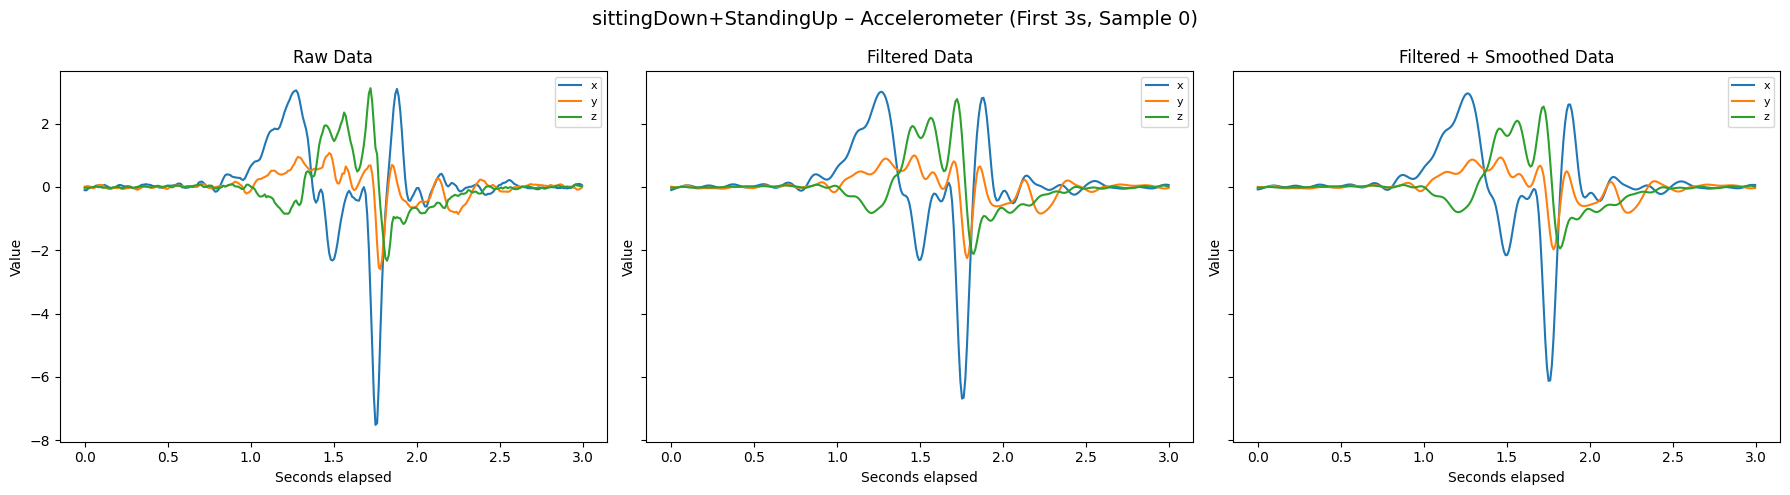

In [291]:
action = "sittingDown+StandingUp"
sensor = "Accelerometer"

# Collect your sample sets with labels
data_sets = {
    "Raw Data": raw_data,
    "Filtered Data": filtered_data,
    "Filtered + Smoothed Data": smoothed_filtered_data,
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (label, data) in zip(axes, data_sets.items()):
    df = data[action][sensor][0]  # take first sample
    df_limited = df[df["seconds_elapsed"] <= 3]  # limit to first 10s
    
    ax.plot(df_limited["seconds_elapsed"], df_limited["x"], label="x")
    ax.plot(df_limited["seconds_elapsed"], df_limited["y"], label="y")
    ax.plot(df_limited["seconds_elapsed"], df_limited["z"], label="z")
    
    ax.set_title(label)
    ax.set_xlabel("Seconds elapsed")
    ax.set_ylabel("Value")
    ax.legend(fontsize=8)

fig.suptitle(f"{action} – {sensor} (First 3s, Sample 0)", fontsize=14)
plt.tight_layout()
plt.show()



> These plots show that applying smoothing after filtering does not noticeably alter the signals. Therefore, we will proceed using only the filtered data in the next steps.

## 🧩 Sample Construction

### Defining Functions for Constructiong Samples

Two helper functions are defined to ensure the data can be split into consistent samples:  

1. **`_split_into_samples`:**   
    - Uses the `seconds_elapsed` column to create contiguous chunks of 5 seconds (default).
    - Each chunk is re-timed so that its `seconds_elapsed` column starts at `t = 0s`.  
    - Any trailing segment shorter than the window size is discarded.  
    - Returns a list of DataFrames, where each DataFrame corresponds to one time window.  

2. **`build_samples`:**  
    - Iterates over all actions, sensors, and recordings.  
    - Calls `_split_into_samples` on each recording to generate 5-second samples.  
    - Aggregates the resulting samples into a nested dictionary of the form:  
      ```python
      {
          action: {
              sensor: [DataFrame, DataFrame, ...]
          }
      }
      ```  
      where each list contains all 5-second samples for that sensor/action.  
    - Handles the special case `"sittingDown+StandingUp"` by splitting alternating windows into two separate actions:  
        - Even-indexed windows → `"sittingDown"`  
        - Odd-indexed windows → `"standingUp"`.  

In [292]:
def _split_into_samples(data: pd.DataFrame, window_s: float = 5.0) -> List[pd.DataFrame]:
    """
    Split a single recording into fixed-length, non-overlapping time windows.

    Uses the "seconds_elapsed" column to create contiguous chunks of length
    "window_s" seconds. Each chunk is re-timed so that it starts at t = 0s.

    Parameters
    ----------
    data : pd.DataFrame
        Input DataFrame containing a "seconds_elapsed" column and sensor axes.
    window_s : float, optional
        Window length in seconds for each sample (default is 5.0).

    Returns
    -------
    list of pd.DataFrame
        A list of DataFrames, each representing one time window with
        "seconds_elapsed" reset to start at 0.
    """
    # Identify the end time of the recording
    t_end = float(data["seconds_elapsed"].iloc[-1])

    # Output container for all sample chunks
    out: List[pd.DataFrame] = []

    # Initialize window start at t = 0s
    start = 0.0

    # Iterate over windows until reaching the end
    while start + window_s <= t_end + 1e-9:
        # End time for current window
        end = start + window_s

        # Select rows inside [start, end)
        mask = (data["seconds_elapsed"] >= start) & (data["seconds_elapsed"] < end)
        chunk = data.loc[mask].copy()

        # Rebase time so that the window starts at t = 0s
        chunk["seconds_elapsed"] = chunk["seconds_elapsed"] - chunk["seconds_elapsed"].iloc[0]

        # Append cleaned, reindexed chunk
        out.append(chunk.reset_index(drop=True))

        # Advance to next window
        start = end

    return out


def build_samples(data: Dict[str, Dict[str, List[pd.DataFrame]]]) -> Dict[str, Dict[str, List[pd.DataFrame]]]:
    """
    Convert recordings into fixed-length samples per action and sensor.

    For each "action" and "sensor", splits every recording DataFrame into
    5-second samples using "_split_into_samples" and aggregates them. The
    special action "sittingDown+StandingUp" is split into two separate actions:
    "sittingDown" and "standingUp" by alternating windows (even/odd).

    Parameters
    ----------
    data : dict
        Nested dictionary of the form "{action: {sensor: [pd.DataFrame, ...]}}",
        where each DataFrame is a full recording with columns including
        "seconds_elapsed" and sensor axes (e.g., "x", "y", "z").

    Returns
    -------
    dict
        Nested dictionary mapping
        "{ action: { sensor: [pd.DataFrame, ...] } }", where each list contains
        5-second samples for that sensor/action.
    """
    # Output container mirroring the input structure but with samples
    samples: Dict[str, Dict[str, List[pd.DataFrame]]] = {}

    # Iterate over actions in the dataset
    for action, sensors in data.items():
        # Initialize action keys
        if action != "sittingDown+StandingUp":
            samples[action] = {}
        else:
            samples["sittingDown"] = {}
            samples["standingUp"] = {}

        # Iterate over sensors for this action
        for sensor, recordings in sensors.items():
            if action != "sittingDown+StandingUp":
                # Aggregate all 5s samples for this sensor/action
                sensor_samples: List[pd.DataFrame] = []
                for rec_df in recordings:
                    split_samples = _split_into_samples(rec_df, window_s=5.0)
                    sensor_samples.extend(split_samples)
                samples[action][sensor] = sensor_samples
            else:
                # Split alternating windows into sittingDown / standingUp
                sitting_down_samples: List[pd.DataFrame] = []
                standing_up_samples: List[pd.DataFrame] = []

                for rec_df in recordings:
                    split_samples = _split_into_samples(rec_df, window_s=5.0)
                    # Even-indexed windows → sitting down
                    sitting_down_samples.extend(split_samples[0::2])
                    # Odd-indexed windows → standing up
                    standing_up_samples.extend(split_samples[1::2])

                samples["sittingDown"][sensor] = sitting_down_samples
                samples["standingUp"][sensor] = standing_up_samples

    return samples

### Construct Samples  
The smoothed and filtered data is transformed into separate 5-second samples. 

In [293]:
samples = build_samples(smoothed_filtered_data)

### Visualize Sample Distubution

In [294]:
# Collect and print actions / sensors
actions = list(samples.keys())
# union of sensors across all actions (robust if some actions miss a sensor)
all_sensors = sorted({sensor for a in samples.values() for sensor in a.keys()})

# Build counts table: rows=actions, cols=sensors
rows = []
for action in actions:
    for sensor in all_sensors:
        n = len(samples[action].get(sensor, []))  # 0 if sensor missing for action
        rows.append({"action": action, "sensor": sensor, "n_samples": n})

counts_df = pd.DataFrame(rows).pivot(index="action", columns="sensor", values="n_samples").fillna(0).astype(int)
print("\nCounts per (action, sensor):")
print(counts_df)


Counts per (action, sensor):
sensor          Accelerometer  Gravity  Gyroscope
action                                           
climbingStairs            162      162        162
running                   162      162        162
sittingDown               162      162        162
standingUp                162      162        162
walking                   162      162        162


> This table shows that each action–sensor combination contains the same number of samples (162).

## 🪟 Re-window

### Defining Functions for Re-windowing  
Two helper functions are defined to adjust the duration of existing samples by extracting centered sub-windows:  

1. **`_rewindow_center`:**  
    - Takes a single sample (`DataFrame`) and cuts out a centered sub-window of a specified length (`window_s`).  
    - Uses the `seconds_elapsed` column to calculate the start and end times of the centered window.   
    - Rebases the time column so that the extracted window starts at `t = 0s`.  
    - Returns a new `DataFrame` containing only the centered segment of the original sample.  

2. **`rewindow_samples`:**  
    - Iterates over a nested dictionary of samples in the format:  
      ```python
      {
          action: {
              sensor: [DataFrame, DataFrame, ...]
          }
      }
      ```  
    - Applies `_rewindow_center` to each `DataFrame` in the structure.  
    - Produces a new dictionary with the same nested format, but where each sample has been reduced to a centered sub-window of length `window_s`.  

In [295]:
def _rewindow_center(df: pd.DataFrame, window_s: float, time_col: str = "seconds_elapsed") -> pd.DataFrame:
    """
    Extract a centered time window from a recording and reset time to start at 0s.

    The function takes a single recording and returns the centered sub-window of length
    "window_s".

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing a time column (default: "seconds_elapsed") and
        sensor axes.
    window_s : float
        Desired window length in seconds.
    time_col : str, optional
        Name of the time column (default is "seconds_elapsed").

    Returns
    -------
    pd.DataFrame
        A copy of the input restricted to the centered time window, with the time
        column rebased so the window starts at 0 seconds.
    """
    # Determine time bounds and duration
    t0 = float(df[time_col].iloc[0])
    t_end = float(df[time_col].iloc[-1])
    duration = t_end - t0
    if window_s > duration + 1e-9:
        raise ValueError(f"`window_s` ({window_s}) cannot exceed sample duration ({duration:.6f}).")

    # Compute centered window [start, end]
    start = t0 + (duration - window_s) / 2.0
    end = start + window_s

    # Select rows in [start, end] (include end with small epsilon)
    eps = 1e-9
    mask = (df[time_col] >= start - eps) & (df[time_col] <= end + eps)
    chunk = df.loc[mask].copy()

    # Rebase time so the window starts at 0s
    # Guard against degenerate slices
    if not chunk.empty:
        chunk[time_col] = chunk[time_col] - chunk[time_col].iloc[0]
        chunk.reset_index(drop=True, inplace=True)

    return chunk


def rewindow_samples(samples: Dict[str, Dict[str, List[pd.DataFrame]]], window_s: float, time_col: str = "seconds_elapsed") -> Dict[str, Dict[str, List[pd.DataFrame]]]:
    """
    Apply centered rewindowing to a nested dict of samples.

    Expects a structure like:
        { action: { sensor: [DataFrame, DataFrame, ...] } }
    and applies "rewindow_center" to each DataFrame.

    Parameters
    ----------
    samples : dict
        Nested dictionary mapping actions to sensors to lists of sample DataFrames.
    window_s : float
        Desired window length (seconds) to cut from the center of each sample.
    time_col : str, optional
        Name of the time column (default: "seconds_elapsed").

    Returns
    -------
    dict
        Same structure as input, with each DataFrame replaced by its centered window.
    """
    # Initialize output container with the same nested structure
    out: Dict[str, Dict[str, List[pd.DataFrame]]] = {}

    # Loop over all actions
    for action, sensors in samples.items():
        out[action] = {}

        # Loop over all sensors
        for sensor, dfs in sensors.items():
            out[action][sensor] = []

            # Loop over all sample DataFrames for this sensor/action
            for df in dfs:
                # Apply centered rewindowing to the DataFrame
                out[action][sensor].append(
                    _rewindow_center(df, window_s=window_s, time_col=time_col)
                )

    # Return rewindowed samples with the same structure as the input
    return out

### Re-window Samples  
The original 5-second samples are re-windowed to create centered sub-samples of 1, 3, and 5 seconds.  

In [296]:
# Rewindow to 1-second centered slices
samples_1s = rewindow_samples(samples, window_s=1.0)

# Rewindow to 3-second centered slices
samples_3s = rewindow_samples(samples, window_s=3.0)

# Keep as 5s
samples_5s = samples.copy()

### Visualize Re-windowed Samples  
The same recording is visualized at the different window sizes (1s, 3s, and 5s). This is done to demonstrate that the centered cut is applied correctly.  
In addition, the print statement confirms that the total number of samples remains the same after re-windowing.

Number of samples 1s: 162


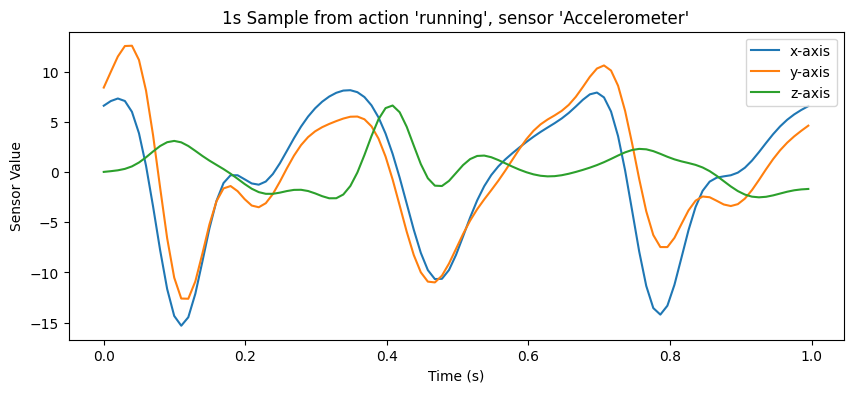

Number of samples 3s: 162


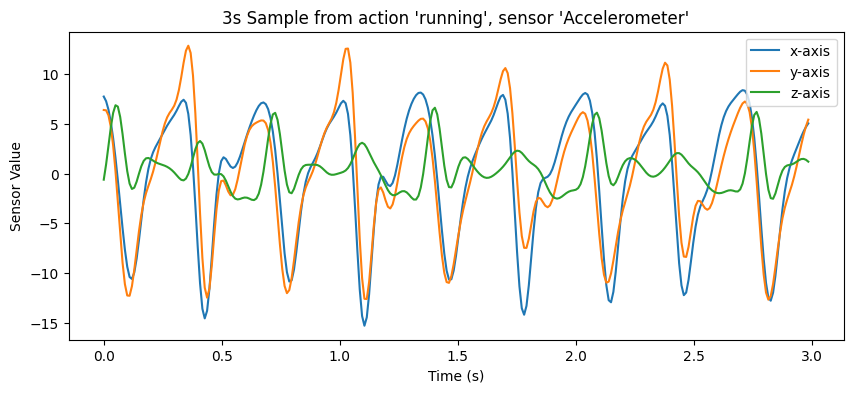

Number of samples 5s: 162


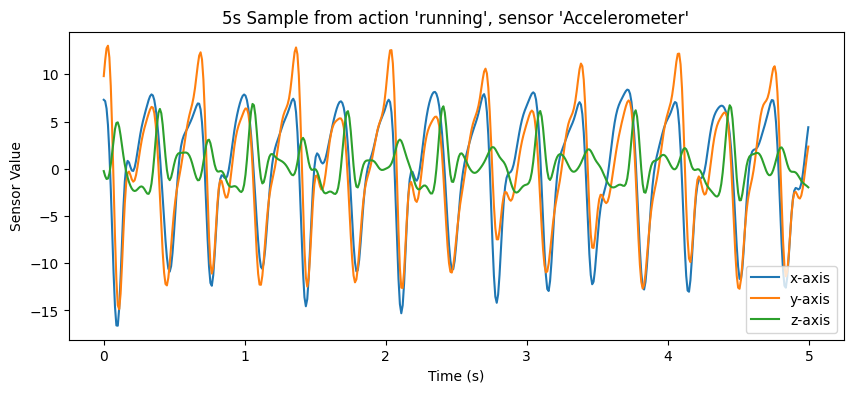

In [297]:
# Define which action and sensor to visualize
action = "running"
sensor = "Accelerometer"

# Collect your sample sets with labels
sample_sets = {
    "1s": samples_1s,
    "3s": samples_3s,
    "5s": samples_5s,
}

# Loop through the sets and plot the first sample
for label, samples in sample_sets.items():
    print("Number of samples {}: {}".format(label, len(samples[action][sensor])))
    df = samples[action][sensor][i]  # first sample
    plt.figure(figsize=(10, 4))
    plt.plot(df["seconds_elapsed"], df["x"], label="x-axis")
    plt.plot(df["seconds_elapsed"], df["y"], label="y-axis")
    plt.plot(df["seconds_elapsed"], df["z"], label="z-axis")
    plt.xlabel("Time (s)")
    plt.ylabel("Sensor Value")
    plt.title(f"{label} Sample from action '{action}', sensor '{sensor}'")
    plt.legend()
    plt.show()

> In the plots it is clearly visable that the 1-second and 3-second samples are **centered cuts** taken from the original 5-second window.

## ✂️ Data Splitting

### Defining Function to Split Data
### Defining Function to Split Samples into Train, Validation, and Test Sets  

The function `split_samples` is used to randomly divide the dataset into **training**, **validation**, and **test** sets with user-defined ratios.  

- **`split_samples`:**  
  - Iterates over all actions and sensors in the dataset.  
  - Randomly shuffles the sample indices for each sensor to avoid ordering bias.  
  - Splits the samples into **train**, **val**, and **test** subsets according to the given ratios (`train_ratio`, `val_ratio`, `test_ratio`).   
  - Uses the **largest remainder method** to handle rounding so that all samples are allocated and the split sizes are as close as possible to the requested ratios.  
  - Returns three nested dictionaries, each with the structure:  
    ```python
    {
        action: {
            sensor: [DataFrame, DataFrame, ...]
        }
    }
    ```
    where the lists contain the assigned samples for training, validation, or testing.  

In [298]:
def split_samples(samples: Dict, train_ratio: float, val_ratio: float = 0.1, test_ratio: float = 0.1, seed: int = 42) -> Tuple:
    """
    Split samples into train, validation, and test sets.

    For each action and sensor, the function randomly assigns samples into
    training, validation, and test sets according to the given ratios.

    Parameters
    ----------
    samples : dict
        Nested dictionary of the form
        "{action: {sensor: [pd.DataFrame, ...]}}" containing all samples.
    train_ratio : float
        Fraction of samples to assign to the training set.
    val_ratio : float, optional
        Fraction of samples to assign to the validation set (default is 0.1).
    test_ratio : float, optional
        Fraction of samples to assign to the test set (default is 0.1).
    seed : int, optional
        Random seed for reproducibility (default is 42).

    Returns
    -------
    train : dict
        Nested dictionary containing the training samples with the same structure
        as "samples".
    val : dict
        Nested dictionary containing the validation samples with the same structure
        as "samples".
    test : dict
        Nested dictionary containing the test samples with the same structure
        as "samples".
    """
    # Basic validation of ratios
    if not (0 <= train_ratio <= 1 and 0 <= val_ratio <= 1 and 0 <= test_ratio <= 1):
        raise ValueError("All ratios must be in [0, 1].")
    total_ratio = train_ratio + val_ratio + test_ratio
    if abs(total_ratio - 1.0) > 1e-9:
        raise ValueError("train_ratio + val_ratio + test_ratio must sum to 1.0.")

    # Initialize output containers
    train = {action: {sensor: [] for sensor in sensors} for action, sensors in samples.items()}
    val   = {action: {sensor: [] for sensor in sensors} for action, sensors in samples.items()}
    test  = {action: {sensor: [] for sensor in sensors} for action, sensors in samples.items()}

    # Random generator for reproducibility
    random_number = random.Random(seed)

    # Loop over actions and sensors
    for action in samples.keys():
        for sensor in samples[action].keys():
            sample_list = samples[action][sensor]
            n = len(sample_list)

            # Create shuffled index list
            sample_nums = list(range(n))
            random_number.shuffle(sample_nums)

            # Compute split sizes using largest remainder method for exact totals
            targets = [train_ratio * n, val_ratio * n, test_ratio * n]
            floors = [int(t) for t in targets]
            remainder = n - sum(floors)

            # Distribute the remaining samples to the largest fractional parts
            fracs = [(targets[i] - floors[i], i) for i in range(3)]
            fracs.sort(reverse=True)  # highest fractional parts first
            for k in range(remainder):
                floors[fracs[k][1]] += 1

            n_train, n_val, n_test = floors

            # Split indices into train, val, test
            sample_nums_train = sample_nums[:n_train]
            sample_nums_val   = sample_nums[n_train:n_train + n_val]
            sample_nums_test  = sample_nums[n_train + n_val:n_train + n_val + n_test]

            # Assign samples to train/val/test sets
            train[action][sensor] = [sample_list[i] for i in sample_nums_train]
            val[action][sensor]   = [sample_list[i] for i in sample_nums_val]
            test[action][sensor]  = [sample_list[i] for i in sample_nums_test]

    return train, val, test

### Splitting Samples into Train, Validation, and Test Sets  

The prepared samples (1s, 3s, and 5s windows) are split into **training**, **validation**, and **test** sets.  
80% of the samples are assigned to training, 10% to validation, and 10% to testing.
The seed used to split the data is the same for each tim window to make sure there is no difference in what data is part of a time window

In [299]:
# Using 80% train, 10% val (default), and 10% test
# Seed is the same for all to make no difference between what data is part of the sets of each time window
# Split the 1-second samples into train/val/test sets
train_samples_1s, val_samples_1s, test_samples_1s = split_samples(samples_1s, train_ratio=0.80, val_ratio=0.1, test_ratio=0.1, seed=42)

# Split the 3-second samples into train/val/test sets
train_samples_3s, val_samples_3s, test_samples_3s = split_samples(samples_3s, train_ratio=0.80, val_ratio=0.1, test_ratio=0.1, seed=42)

# Split the 5-second samples into train/val/test sets
train_samples_5s, val_samples_5s, test_samples_5s = split_samples(samples_5s, train_ratio=0.80, val_ratio=0.1, test_ratio=0.1, seed=42)

### Visualize Train, Validation, and Test Sets
A histogram is made that visualizes how the train, validation, and test data is distibuted

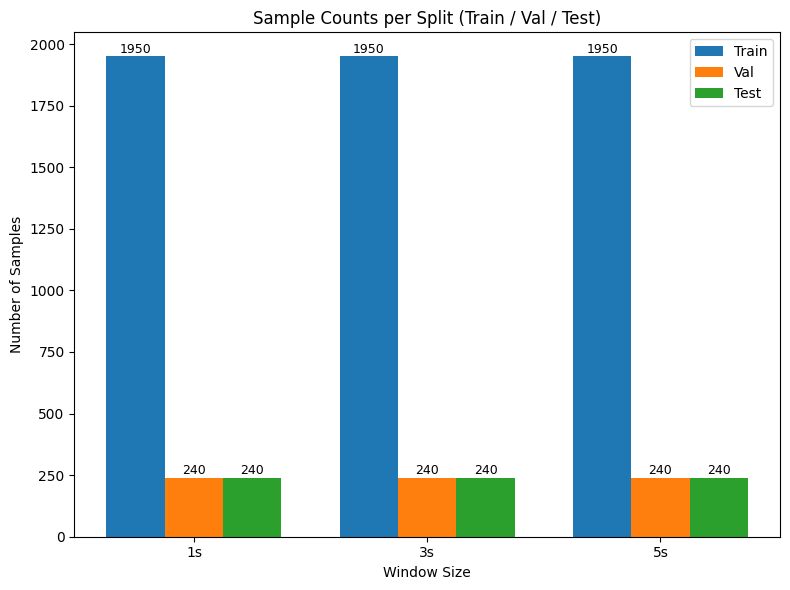

In [300]:
# Collect all splits into a dict for plotting
splits_summary = {
    "1s": (train_samples_1s, val_samples_1s, test_samples_1s),
    "3s": (train_samples_3s, val_samples_3s, test_samples_3s),
    "5s": (train_samples_5s, val_samples_5s, test_samples_5s),
}

# Prepare data for plotting
labels = ["Train", "Val", "Test"]
x = range(len(splits_summary))  # positions for 1s, 3s, 5s
width = 0.25  # bar width

plt.figure(figsize=(8, 6))

# Loop over splits and plot bars
for i, label in enumerate(labels):
    counts = []
    for _, (train, val, test) in splits_summary.items():
        if label == "Train":
            n = sum(len(v) for s in train.values() for v in s.values())
        elif label == "Val":
            n = sum(len(v) for s in val.values() for v in s.values())
        else:  # Test
            n = sum(len(v) for s in test.values() for v in s.values())
        counts.append(n)

    # Create bars
    bar_positions = [p + i * width for p in x]
    bars = plt.bar(bar_positions, counts, width, label=label)

    # Annotate each bar with its count
    for bar, count in zip(bars, counts):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 2,  # offset above bar
            str(count),
            ha="center",
            va="bottom",
            fontsize=9
        )

# Formatting
plt.xticks([p + width for p in x], splits_summary.keys())
plt.xlabel("Window Size")
plt.ylabel("Number of Samples")
plt.title("Sample Counts per Split (Train / Val / Test)")
plt.legend()
plt.tight_layout()
plt.show()


> The histogram shows that each window size has the samples correctly split.

## 🧠 Training

### Flatten Trials and Build Feature Matrices

The functions `_concat_sensors_for_trial` and `build_Xy` are used to convert the data with several sensors and trials into a feature matrix (`X`) and label vector (`y`)** suitable for supervised and unsupervised models later on.

- **`_concat_sensors_for_trial`**  
  - Takes a dictionary mapping sensor names to their trial DataFrames.  
  - Flattens each sensor’s DataFrame into a **1D Series**, preserving the column order.  
  - Prefixes each feature with the sensor name and a numeric index to avoid duplicate column names.  

- **`build_Xy`**  
  - Accepts a nested dictionary of trials, structured as:  
    ```python
    {
        action: {
            sensor: [DataFrame, DataFrame, ...]
        }
    }
    ```  
  - Iterates over each action and trial, ensuring that all sensors have the **same number of trials**.  
  - Calls `_concat_sensors_for_trial` for each trial to generate **one feature vector per trial**.  
  - Collects all feature vectors into a **pandas DataFrame (`X`)**.  
  - Encodes the action labels into numeric form (`y`) using `LabelEncoder`.  
  - Returns:  
    ```python
    X, y
    ```  


In [313]:
def _concat_sensors_for_trial(trial_per_sensor: Dict[str, pd.DataFrame]) -> pd.Series:
    """
    Flatten all sensor DataFrames for a single trial into one feature vector.
    
    Parameters
    ----------
    trial_per_sensor : dict
        Dictionary mapping sensor names to their trial DataFrames.
    
    Returns
    -------
    pd.Series
        A single Series containing all features for this trial, with
        column names prefixed by the sensor name.
    """
    parts = []

    for sensor, df in trial_per_sensor.items():
        # Flatten the DataFrame (row-wise) into a Series
        s = df.stack()  # stacks columns, preserving order
        s.index = pd.Index([f"{sensor}__{col}__{i}" for i, col in enumerate(s.index)])
        parts.append(s)

    # Concatenate all sensors into one Series
    return pd.concat(parts) if parts else pd.Series(dtype=float)

def build_Xy(
    split_dict: Dict[str, Dict[str, List[pd.DataFrame]]]
) -> Tuple[pd.DataFrame, np.ndarray, List[str]]:
    """
    Convert split dictionary (action -> sensor -> list of DataFrames)
    into a feature matrix X, label vector y, and list of class names.

    """
    rows, labels = [], []
    
    for activity, sensors in split_dict.items():
        first_sensor = next(iter(sensors))
        n_trials = len(sensors[first_sensor])

        for sensor, lst in sensors.items():
            if len(lst) != n_trials:
                raise ValueError(
                    f"Inconsistent trials for {activity}: "
                    f"{first_sensor}={n_trials}, {sensor}={len(lst)}"
                )

        for j in range(n_trials):
            trial_per_sensor = {s: sensors[s][j] for s in sensors.keys()}
            rows.append(_concat_sensors_for_trial(trial_per_sensor))
            labels.append(activity)

    X = pd.DataFrame(rows).fillna(0.0).reset_index(drop=True)

    le = LabelEncoder()
    y = le.fit_transform(labels)
    
    return X, y

### Build Feature Matrices for Three Window Sizes

The function `build_all_datasets` is used to process the three window sizes (1s, 3s, 5s) and generate feature matrices (`X`) and label vectors (`y`)** for each of the training, validation, and test splits.

- **`build_all_datasets`:**  
  - Accepts the train, validation, and test sample dictionaries for each window size.  
  - Iterates over each window size (`"1s"`, `"3s"`, `"5s"`).  
  - Calls `build_Xy` on each split to convert into:
    - `X_train`, `y_train`  
    - `X_val`, `y_val`  
    - `X_test`, `y_test`  
  - Stores the results in a directoy under the window size key, structured as:  
    ```python
    datasets[window] = {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
    }
    ```
  - Returns the `datasets` dictionary containing all three window sizes.

In [314]:
def build_all_datasets(
    train_samples_1s, val_samples_1s, test_samples_1s,
    train_samples_3s, val_samples_3s, test_samples_3s,
    train_samples_5s, val_samples_5s, test_samples_5s
):
    datasets = {}

    for win, (tr, va, te) in {
        "1s": (train_samples_1s, val_samples_1s, test_samples_1s),
        "3s": (train_samples_3s, val_samples_3s, test_samples_3s),
        "5s": (train_samples_5s, val_samples_5s, test_samples_5s),
    }.items():
        X_train, y_train, classes = build_Xy(tr)
        X_val,   y_val,   _       = build_Xy(va)
        X_test,  y_test,  _       = build_Xy(te)

        datasets[win] = {
            "X_train": X_train, "y_train": y_train,
            "X_val": X_val,     "y_val": y_val,
            "X_test": X_test,   "y_test": y_test,
        }

    return datasets

### Build Datasets
The code below uses the functions defined above to build the datasets for each window size.

In [ ]:
datasets = build_all_datasets(
    train_samples_1s, val_samples_1s, test_samples_1s,
    train_samples_3s, val_samples_3s, test_samples_3s,
    train_samples_5s, val_samples_5s, test_samples_5s
)

for win in ["1s", "3s", "5s"]:
    globals()[f"X_train_{win}"] = datasets[win]["X_train"]
    globals()[f"X_val_{win}"]   = datasets[win]["X_val"]
    globals()[f"X_test_{win}"]  = datasets[win]["X_test"]
    globals()[f"y_train_{win}"] = datasets[win]["y_train"]
    globals()[f"y_val_{win}"]   = datasets[win]["y_val"]
    globals()[f"y_test_{win}"]  = datasets[win]["y_test"]

## Supervised models

### Evaluation Function

The function `evaluate` defines and computes the desired key performance metrics comparing the true labels (`y_true`) with predicted labels (`y_pred`). It returns a dictionary containing:

- **`accuracy`**: the fraction of correctly predicted labels.  
- **`kappa`**: Cohen's kappa score.
- **`f1_macro`**: the macro-averaged F1 score.

In [315]:
def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    return {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "kappa": float(cohen_kappa_score(y_true, y_pred)),
        "f1_macro": float(f1_score(y_true, y_pred, average="macro")),
    }

### Plotting Results

The function `plot_metrics` creates a standardized method to visualise the key perfomance metrics in a bar plot.

In [341]:
def plot_metrics(metrics_dict: dict, title: str = "Performance Metrics by Window Size"):
    """
    Plots classification metrics (accuracy, kappa, f1_macro) for different window sizes.
    
    Parameters
    ----------
    metrics_dict : dict
        Dictionary with window sizes as keys and metric dictionaries as values.
    title : str
        Title of the plot.
    """
    df = pd.DataFrame(metrics_dict).T  # rows = window sizes, columns = metrics
    
    # Determine y-axis limits dynamically
    min_val = df.min().min()
    max_val = df.max().max()
    ylim_lower = max(0.0, min_val - 0.04)
    ylim_upper = min(1.1, max_val + 0.04)
    
    # Plot
    ax = df.plot(kind="bar", figsize=(8,5), ylim=(ylim_lower, ylim_upper), width=0.7)
    
    # Annotate each bar with its value
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, rotation=0)
    
    plt.title(title, fontsize=14)
    plt.ylabel("Score")
    plt.xlabel("Window Size")
    plt.xticks(rotation=0)
    plt.legend(title="Metric")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### Logistic regression

A **Logistic Regression** model is trained and evaluated for each window size (1s, 3s, 5s). The pipeline which is used automatically applies scaling and principal component analysis:

- For each window size a `Pipeline` is defined containing:
    1. **`StandardScaler`** to normalize features.  
    2. **`PCA`** to reduce dimensionality while retaining 95% of the variance.  

The results are evaluated on the performance metrics as defined before and visualised as such.


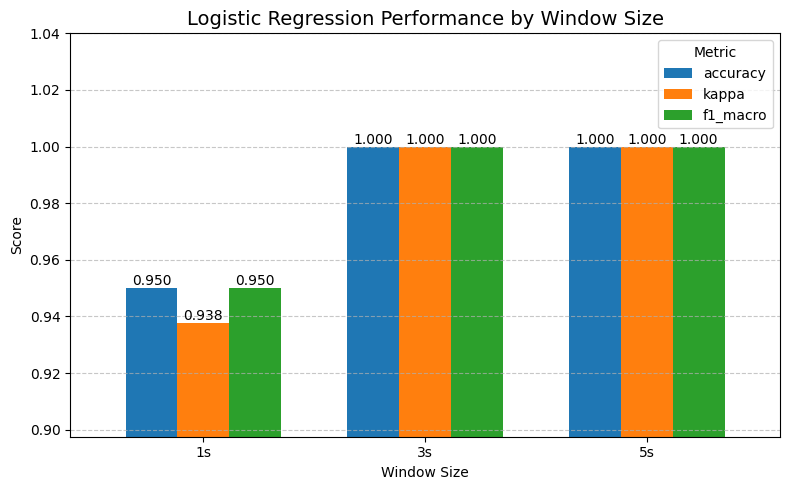

In [342]:
logreg_test_metrics_all = {}

for win in ["1s", "3s", "5s"]:
    
    # Get the training and testing data
    X_train = globals()[f"X_train_{win}"]
    y_train = globals()[f"y_train_{win}"]
    X_test  = globals()[f"X_test_{win}"]
    y_test  = globals()[f"y_test_{win}"]

    # Define pipeline
    logreg = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("clf", LogisticRegression(max_iter=2000, random_state=42))
    ])

    # Fit the model
    logreg.fit(X_train, y_train)

    # Predict on the test set
    y_test_hat = logreg.predict(X_test)

    # Evaluate and store metrics
    test_metrics = evaluate(y_test, y_test_hat)
    logreg_test_metrics_all[win] = test_metrics

# Display results for all window sizes
plot_metrics(logreg_test_metrics_all, title="Logistic Regression Performance by Window Size")

### K-Nearest Neighbor

A **K-Nearest Neighbor** model is trained and evaluated for each window size (1s, 3s, 5s). The pipeline which is used automatically applies scaling and principal component analysis:

- For each window size a `Pipeline` is defined containing:
    1. **`StandardScaler`** to normalize features.  
    2. **`PCA`** to reduce dimensionality while retaining 95% of the variance.  

The results are evaluated on the performance metrics as defined before and visualised as such.

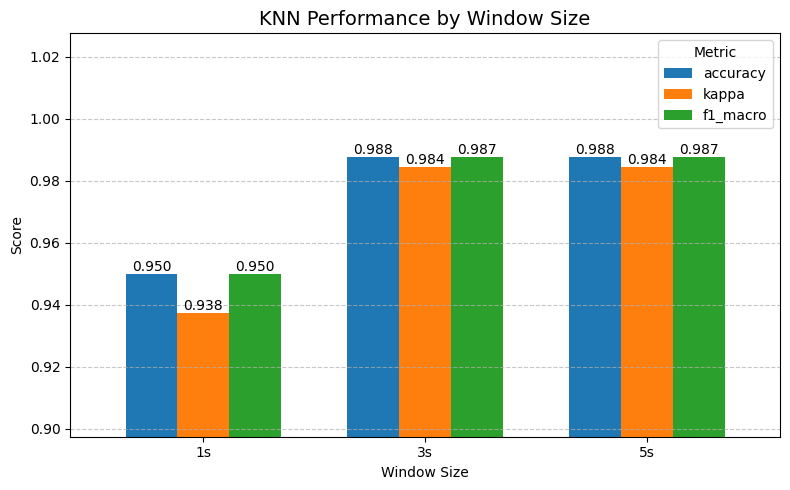

In [343]:
knn_test_metrics_all = {}

for win in ["1s", "3s", "5s"]:
    
    # Retrieve train and test data
    X_train = globals()[f"X_train_{win}"]
    y_train = globals()[f"y_train_{win}"]
    X_test  = globals()[f"X_test_{win}"]
    y_test  = globals()[f"y_test_{win}"]
    
    # Define pipeline
    knn = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ])
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    # Predict on test set
    y_test_hat = knn.predict(X_test)
    
    # Evaluate and store metrics
    test_metrics = evaluate(y_test, y_test_hat)
    knn_test_metrics_all[win] = test_metrics

# Display results for all window sizes
plot_metrics(knn_test_metrics_all, title="KNN Performance by Window Size")

### Gaussian Naive Bayes

A **Gaussian Naive Bayes** model is trained and evaluated for each window size (1s, 3s, 5s). The pipeline which is used automatically applies scaling and principal component analysis:

- For each window size a `Pipeline` is defined containing:
    1. **`StandardScaler`** to normalize features.  
    2. **`PCA`** to reduce dimensionality while retaining 95% of the variance.  

The results are evaluated on the performance metrics as defined before and visualised as such.

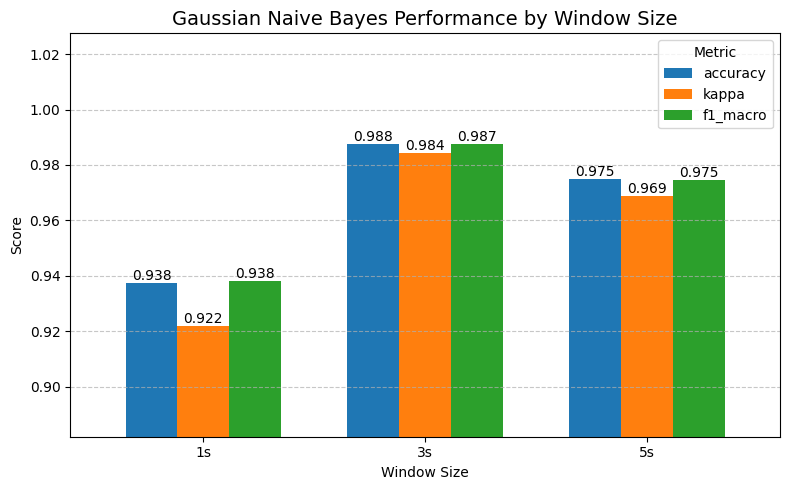

In [344]:
gnb_test_metrics_all = {}

for win in ["1s", "3s", "5s"]:
    
    # Retrieve train and test data 
    X_train = globals()[f"X_train_{win}"]
    y_train = globals()[f"y_train_{win}"]
    X_test  = globals()[f"X_test_{win}"]
    y_test  = globals()[f"y_test_{win}"]
    
    # Define Pipeline
    gnb = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("clf", GaussianNB())
    ])
    
    # Fit the model
    gnb.fit(X_train, y_train)
    
    # Predict on test set
    y_test_hat = gnb.predict(X_test)
    
    # Evaluate and store metrics
    test_metrics = evaluate(y_test, y_test_hat)
    gnb_test_metrics_all[win] = test_metrics

# Display results for all window sizes
plot_metrics(gnb_test_metrics_all, title="Gaussian Naive Bayes Performance by Window Size")

### Decision Tree

A **Decision Tree** model is trained and evaluated for each window size (1s, 3s, 5s). The pipeline which is used automatically applies principal component analysis; scaling is not required for a decision tree:

- For each window size a `Pipeline` is defined containing:
    1. **`PCA`** to reduce dimensionality while retaining 95% of the variance.  

The results are evaluated on the performance metrics as defined before and visualised as such.

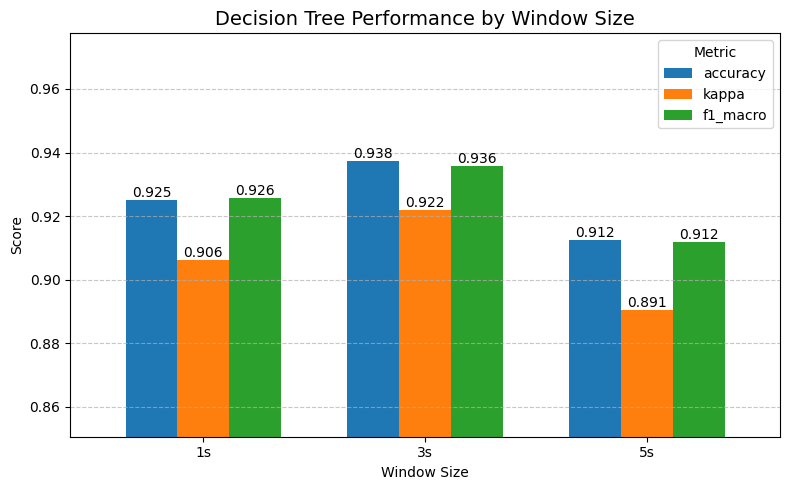

In [345]:
dt_test_metrics_all = {}

for win in ["1s", "3s", "5s"]:
    
    # Retrieve train and test data
    X_train = globals()[f"X_train_{win}"]
    y_train = globals()[f"y_train_{win}"]
    X_test  = globals()[f"X_test_{win}"]
    y_test  = globals()[f"y_test_{win}"]
    
    # Define pipeline
    dt_pipe = Pipeline([
        ("pca", PCA(n_components=0.95)),
        ("clf", DecisionTreeClassifier(random_state=42))
    ])
    
    # Fit the model
    dt_pipe.fit(X_train, y_train)
    
    # Predict on test set
    y_test_hat = dt_pipe.predict(X_test)
    
    # Evaluate and store metrics
    test_metrics = evaluate(y_test, y_test_hat)
    dt_test_metrics_all[win] = test_metrics

# Display results for all window sizes
plot_metrics(dt_test_metrics_all, title="Decision Tree Performance by Window Size")


## Unsupervised models

### Cluster Alignment Function  

For the unsupervised models, The function `align_clusters` is first created. This function ensures that cluster labels are mapped consistently to the true class labels. 

The function:
- Builds a **confusion matrix** between true labels (`y_true`) and cluster assignments (`y_cluster`).  
- Uses the algorithm (`linear_sum_assignment`) to find the optimal one-to-one mapping between clusters and true labels.  

In [348]:
def align_clusters(y_true: np.ndarray, y_cluster: np.ndarray, n_classes: int) -> Tuple[np.ndarray, Dict[int, int]]:
    C = confusion_matrix(y_true, y_cluster, labels=np.arange(n_classes))
    cost = C.max() - C
    r, c = linear_sum_assignment(cost)
    mapping = {cluster: cls for cluster, cls in zip(c, r)}
    y_aligned = np.array([mapping[z] for z in y_cluster])
    return y_aligned, mapping

### k-Means

A **k-means** model is trained and evaluated for each window size (1s, 3s, 5s). The pipeline which is used automatically applies scaling and principal component analysis:

- For each window size a `Pipeline` is defined containing:
    1. **`StandardScaler`** to normalize features.  
    2. **`PCA`** to reduce dimensionality while retaining 95% of the variance.  

The results are evaluated on the performance metrics as defined before and visualised as such.

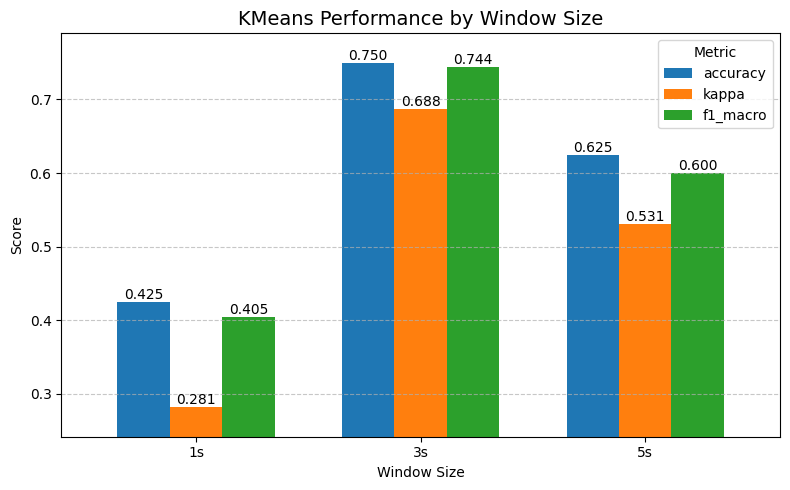

In [349]:
kmeans_test_metrics_all = {}

for win in ["1s", "3s", "5s"]:
    
    # Retrieve train and test data
    X_train = globals()[f"X_train_{win}"]
    y_train = globals()[f"y_train_{win}"]
    X_val   = globals()[f"X_val_{win}"]
    y_val   = globals()[f"y_val_{win}"]
    
    # Define pipeline
    kmeans_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("kmeans", KMeans(n_clusters=len(np.unique(y_train)), n_init="auto", random_state=42))
    ])
    
    # Fit on training data
    kmeans_pipe.fit(X_train)
    k_train = kmeans_pipe["kmeans"].labels_
    
    # Predict clusters
    k_val = kmeans_pipe.predict(X_val)
    
    # Align clusters
    y_train_aligned, map_k = align_clusters(y_train, k_train, n_classes=len(np.unique(y_train)))
    y_val_aligned = np.array([map_k[z] for z in k_val])
    
    # Evaluate and store metrics
    test_metrics = evaluate(y_val, y_val_aligned)
    kmeans_test_metrics_all[win] = test_metrics

# Display results for all window sizes
plot_metrics(kmeans_test_metrics_all, title="KMeans Performance by Window Size")

### Gaussian Mixture Model

A **Gaussian Mixture Model** is trained and evaluated for each window size (1s, 3s, 5s). The pipeline which is used automatically applies scaling and principal component analysis:

- For each window size a `Pipeline` is defined containing:
    1. **`StandardScaler`** to normalize features.  
    2. **`PCA`** to reduce dimensionality while retaining 95% of the variance.  

The results are evaluated on the performance metrics as defined before and visualised as such.

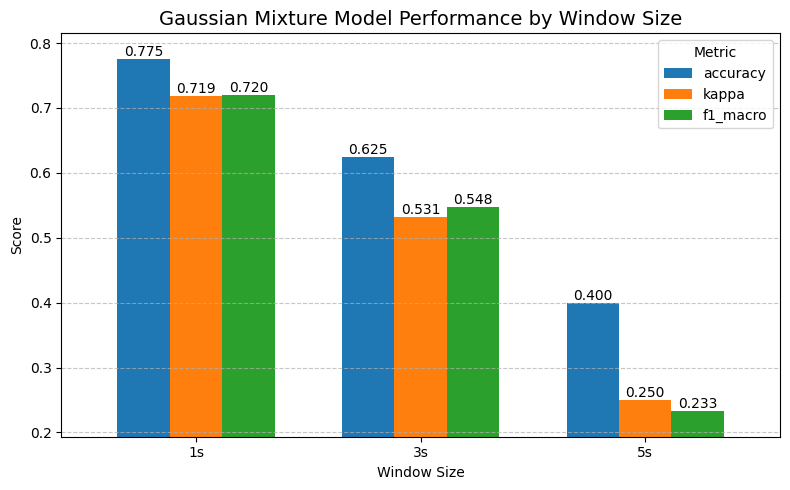

In [354]:
gmm_test_metrics_all = {}

for win in ["1s", "3s", "5s"]:
    
    # Retrieve train and test data
    X_train = globals()[f"X_train_{win}"]
    y_train = globals()[f"y_train_{win}"]
    X_test  = globals()[f"X_test_{win}"]
    y_test  = globals()[f"y_test_{win}"]
    
    # Define pipeline
    gmm_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),  # retain 30% variance
        ("gmm", GaussianMixture(
            n_components=len(np.unique(y_train)), 
            covariance_type="full", 
            random_state=42
        ))
    ])
    
    # Fit on training data
    gmm_pipe.fit(X_train)
    
    # Predict clusters 
    g_train = gmm_pipe.predict(X_train)
    g_test  = gmm_pipe.predict(X_test)
    
    # Align clusters
    y_train_aligned, map_g = align_clusters(y_train, g_train, n_classes=len(np.unique(y_train)))
    y_test_aligned = np.array([map_g[z] for z in g_test])
    
    # Evaluate and store metrics
    test_metrics = evaluate(y_test, y_test_aligned)
    gmm_test_metrics_all[win] = test_metrics

# Display results for all window sizes
plot_metrics(gmm_test_metrics_all, title="Gaussian Mixture Model Performance by Window Size")

### Fuzzy C-Means

A **Fuzzy C-Means** model is trained and evaluated for each window size (1s, 3s, 5s). The pipeline which is used automatically applies scaling and principal component analysis:

- For each window size a `Pipeline` is defined containing:
    1. **`StandardScaler`** to normalize features.  
    2. **`PCA`** to reduce dimensionality while retaining 90% of the variance.  

The results are evaluated on the performance metrics as defined before and visualised as such.

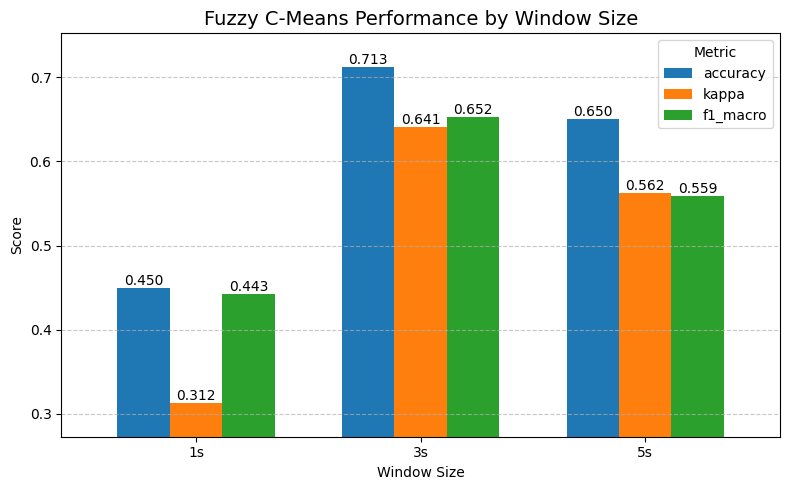

In [356]:
fcm_test_metrics_all = {}

for win in ["1s", "3s", "5s"]:
    
    # Retrieve train and test data
    X_train = globals()[f"X_train_{win}"]
    y_train = globals()[f"y_train_{win}"]
    X_test  = globals()[f"X_test_{win}"]
    y_test  = globals()[f"y_test_{win}"]
    
    # Scale the data
    scaler = StandardScaler().fit(X_train.values)
    X_train_scaled = scaler.transform(X_train.values)
    X_test_scaled  = scaler.transform(X_test.values)

    # Apply PCA (retain 90% variance)
    pca = PCA(n_components=0.90)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca  = pca.transform(X_test_scaled)

    # Transpose
    Xtr = X_train_pca.T
    Xte = X_test_pca.T
    
    # Train FCM
    cntr, u_tr, _, _, _, _, _ = fuzz.cluster.cmeans(
        data=Xtr, c=len(np.unique(y_train)), m=2.0, error=1e-5, maxiter=1000, seed=42
    )
    f_train = np.argmax(u_tr, axis=0)
    
    # Align clusters
    y_train_aligned, map_f = align_clusters(y_train, f_train, n_classes=len(np.unique(y_train)))
    
    # Predict on test set using trained centers
    u_te, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
        test_data=Xte, cntr_trained=cntr, m=2.0, error=1e-8, maxiter=50
    )
    f_test = np.argmax(u_te, axis=0)
    y_test_aligned = np.array([map_f[z] for z in f_test])
    
    # Evaluate and store metrics
    test_metrics = evaluate(y_test, y_test_aligned)
    fcm_test_metrics_all[win] = test_metrics

# Display results for all window sizes
plot_metrics(fcm_test_metrics_all, title="Fuzzy C-Means Performance by Window Size")
